# Capstone Project - Scores for shoe features and ratings

If shoes are not discontinued, it means they are still in production.

Filtering out the discontinued shoes will effectively leave us with the few latest iterations (versions) of each particular shoe model.

__Recommendation for running shoes based on:__
- [Similar shoe features](#shortcut1)
- [User's profile](#shortcut2)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 50)

from collections import defaultdict, Counter
import string
import re
import codecs
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MultiLabelBinarizer, MinMaxScaler, StandardScaler

### Reading in cleaned shoe data

In [2]:
df = pickle.load(open('shoe_data.pkl', 'rb'))

In [3]:
# Remove discontinued shoes.
df = df[df['discontinued'] == 0]
df = df.reset_index(drop=True)
df.head()

,name,brand,core_score,user_review_count,expert_review_count,user_rating,expert_rating,user_5star,user_4star,user_3star,user_2star,user_1star,discontinued,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight,toe_drop,heel_height,forefoot_height,width,good_summary,bad_summary,summary,info,size_fit,outsole,midsole,upper,weight_m,weight_w,toe_drop_m,toe_drop_w,heel_height_m,heel_height_w,forefoot_height_m,forefoot_height_w,width_m,width_w,zero_drop_m,zero_drop_w,low_drop_m,low_drop_w
0,Hoka One One Bondi 6,Hoka One One,91,794,7,4.2,92.0,64,14,9,7,6,0,1,Neutral,1,0,0,1,0,0,290,Men: 309g;Women: 244g;,Men: 4mm;Women: 4mm;,Men: 36mm;Women: 36mm;,Men: 32mm;Women: 32mm;,"Men: Narrow, Standard, Wide;Women: Narrow, Sta...",People mostly liked the cushioning capacity of...,Several consumers felt that the Hoka One One B...,People were mostly happy with the Hoka One One...,Hoka One One is a brand that prides itself in ...,The Hoka One One Bondi 6 was created to be tru...,The rubber compound that’s used for the outsol...,A Soft EVA Midsole serves as the cushioning un...,The upper unit of the Hoka One One Bondi 6 mak...,309,244,4,4,36,36,32,32,"Narrow, Standard, Wide","Narrow, Standard, Wide",0,0,1,1
1,Nike Air Zoom Pegasus 36,Nike,91,16,13,4.8,90.0,81,19,0,0,0,0,1,Neutral,1,0,0,0,0,0,230,Men: 283g;Women: 227g;,Men: 10mm;Women: 10mm;,Men: 28mm;Women: 29mm;,Men: 18mm;Women: 19mm;,"Men: Standard, Wide, Extra wide;Women: Standar...",ome people claimed that the underfoot cushioni...,A couple of purchasers claimed that the width ...,The Air Zoom Pegasus 36 was generally able to ...,The Nike Air Zoom Pegasus 36 is an update to a...,The Nike Air Zoom Pegasus 36 was made using th...,The forefoot section of the Nike Air Zoom Pega...,Cushlon is the primary cushioning unit of the ...,The upper unit of the Nike Air Zoom Pegasus 36...,283,227,10,10,28,29,18,19,"Standard, Wide, Extra wide","Standard, Wide",0,0,0,0
2,Asics Gel Nimbus 21,Asics,91,1150,8,4.4,88.0,71,13,4,6,6,0,1,Neutral,1,0,0,0,0,0,290,Men: 310g;Women: 255g;,Men: 10mm;Women: 13mm;,Men: 23mm;Women: 25mm;,Men: 13mm;Women: 12mm;,"Men: Narrow, Standard, Wide, Extra wide;Women:...",Most users admired the overall structure of th...,It is very expensive compared to other road ru...,Majority of the users were welcoming and happy...,Designed for neutral runners who are looking f...,The Asics Gel Nimbus 21 runs true to size. It ...,In the outsole of the Gel Nimbus 21 is the ASI...,"For a more energetic and lighter run, Asics ma...",The upper of the Asics Gel Nimbus 21 makes use...,310,255,10,13,23,25,13,12,"Narrow, Standard, Wide, Extra wide","Narrow, Standard, Wide",0,0,0,0
3,Brooks Glycerin 17,Brooks,94,699,6,4.5,89.0,75,12,7,3,3,0,1,Neutral,1,0,0,0,0,0,290,Men: 300g;Women: 261g;,Men: 10mm;Women: 10mm;,Men: 32mm;Women: 32mm;,Men: 22mm;Women: 22mm;,"Men: Standard, Wide;Women: Narrow, Standard, W...",The underfoot cushioning system of the Brooks ...,Some purchasers didn’t like the color schemes ...,Overwhelmingly positive feedback was given to ...,The Glycerin 17 is a member of the global fami...,Regular sizing methods were used in the making...,The outsole unit of the Brooks Glycerin 17 is ...,The midsole unit of the Brooks Glycerin 17 is ...,The upper unit of the Brooks Glycerin 17 featu...,300,261,10,10,32,32,22,22,"Standard, Wide","Narrow, Standard, Wide",0,0,0,0
4,Nike Epic React Flyknit 2,Nike,89,547,5,4.2,87.0,61,18,10,5,6,0,1,Neutral,0,0,0,0,0,0,290,Men: 239g;Women: 196g;,Men: 10mm;Women: 10mm;,Men: 28mm;Women: 28mm;,Men: 18mm;Women: 18mm;,"Men: Standard;Women: Standard, Wide;",Several satisfied users lauded the good-lookin...,The shoe is expensive compared to other road r...,"Following the phrase `If it’s not broken, do n...",The first Epic React Flyknit model has become ...,"As per Nike’s official website, the Nike Epic ...",In the outsole of the Nike Epic React Flyknit ...,The Epic React Flyknit 2 features the popular ...,In the upper of this neutr

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 49 columns):
name                   326 non-null object
brand                  326 non-null object
core_score             326 non-null int64
user_review_count      326 non-null int64
expert_review_count    326 non-null int64
user_rating            326 non-null float64
expert_rating          326 non-null float64
user_5star             326 non-null int64
user_4star             326 non-null int64
user_3star             326 non-null int64
user_2star             326 non-null int64
user_1star             326 non-null int64
discontinued           326 non-null int64
terrain                326 non-null int64
arch_support           326 non-null object
use                    326 non-null int64
waterproof             326 non-null int64
water_repellent        326 non-null int64
maximalist             326 non-null int64
minimalist             326 non-null int64
triathlon              326 non-null int64
price 

### Create similarity matrices

#### Create similarity matrix for shoe width

In [5]:
# Convert each width string into a list.
df['width_m'] = df['width_m'].map(lambda x: x.split(", "))
df['width_w'] = df['width_w'].map(lambda x: x.split(", "))

In [6]:
# unique_widths = ['Narrow', 'Standard', 'Wide', 'Extra wide']

In [7]:
# MultiLabelBinarize width matrices
mlb = MultiLabelBinarizer()

width_m_matrix = pd.DataFrame(mlb.fit_transform(df['width_m']),columns=mlb.classes_, index=df.index)
width_w_matrix = pd.DataFrame(mlb.fit_transform(df['width_w']),columns=mlb.classes_, index=df.index)

In [8]:
# Width of men's shoes
print(width_m_matrix.shape)
width_m_matrix.head(5)

(326, 4)


,Extra wide,Narrow,Standard,Wide
0,0,1,1,1
1,1,0,1,1
2,1,1,1,1
3,0,0,1,1
4,0,0,1,0


In [9]:
# Width of women's shoes
print(width_w_matrix.shape)
width_w_matrix.head(5)

(326, 4)


,Extra wide,Narrow,Standard,Wide
0,0,1,1,1
1,0,0,1,1
2,0,1,1,1
3,0,1,1,1
4,0,0,1,1


#### Create similarity matrices for other shoe features

In [10]:
# Function to one-hot encode
def one_hot_encode(series_items, unique_set):
    dummies = np.zeros((df.shape[0], len(unique_set)))
    for row, shoe_items in enumerate(series_items):
        for col, item in enumerate(unique_set):
#             if type(shoe_items) == list:
            if item in shoe_items:
                dummies[row, col] = 1
    # convert to dataframe
    dummies_matrix = pd.DataFrame(dummies, columns=unique_set)
    return dummies_matrix

In [11]:
# Function to create the cosine similarity matrix
def create_cos_sim(num_shoes, matrix):
    # create empty matrix
    cos_sim = np.zeros((num_shoes, num_shoes))
    # calculate cosine similarity for each pair of shoes
    for r in tqdm(range(num_shoes)):
        for c in range(num_shoes):
            x = matrix.iloc[r,:].values.reshape(1, -1)
            y = matrix.iloc[c,:].values.reshape(1, -1)
            cos_sim[r,c] = cosine_similarity(x,y)
    # convert into dataframe
    cos_sim_df = pd.DataFrame(cos_sim)
    return cos_sim_df

#### Create similarity matrix for shoe brand

In [12]:
# Get unique list of brands from all shoes
brand_list = list(df.brand.unique())
print(brand_list)
# one-hot-encode brand matrix
brand_matrix = one_hot_encode(df.brand, brand_list)
brand_matrix.shape

['Hoka One One', 'Nike', 'Asics', 'Brooks', 'Adidas', 'Altra', 'New Balance', 'Saucony', 'Salomon', 'Mizuno', 'Merrell', 'On', 'Skechers', 'Reebok', 'Topo Athletic', 'La Sportiva', 'Inov-8', 'Vibram FiveFingers', 'Under Armour', 'Vivobarefoot', 'The North Face', 'Newton', 'Scott', '361 Degrees', 'Salming', 'Puma']


(326, 26)

#### Create similarity matrix for shoe terrain

In [13]:
terrain_matrix = df.filter(items=['terrain'])
terrain_matrix.shape

(326, 1)

#### Create similarity matrix for shoe arch support

In [14]:
# get unique list of arch support from all shoes
arch_list = list(df.arch_support.unique())
print(arch_list)
# one-hot-encode arch support matrix
arch_matrix = one_hot_encode(df.arch_support, arch_list)
arch_matrix.shape

['Neutral', 'Motion control', 'Stability']


(326, 3)

#### Create similarity matrix for shoe use

In [15]:
use_matrix = df.filter(items=['use'])
use_matrix.shape

(326, 1)

#### Create similarity matrix for zero drop shoes

In [16]:
zero_drop_m_matrix = df.filter(items=['zero_drop_m'])
zero_drop_m_matrix.shape

(326, 1)

In [17]:
zero_drop_w_matrix = df.filter(items=['zero_drop_w'])
zero_drop_w_matrix.shape

(326, 1)

#### Create similarity matrix for low drop shoes

In [18]:
low_drop_m_matrix = df.filter(items=['low_drop_m'])
low_drop_m_matrix.shape

(326, 1)

In [19]:
low_drop_w_matrix = df.filter(items=['low_drop_w'])
low_drop_w_matrix.shape

(326, 1)

#### Create similarity matrix for waterproof shoes

In [20]:
waterproof_matrix = df.filter(items=['waterproof'])
waterproof_matrix.shape

(326, 1)

#### Create similarity matrix for water repellent shoes

In [21]:
water_repellent_matrix = df.filter(items=['water_repellent'])
water_repellent_matrix.shape

(326, 1)

#### Create similarity matrix for maximalist shoes

In [22]:
maximalist_matrix = df.filter(items=['maximalist'])
maximalist_matrix.shape

(326, 1)

#### Create similarity matrix for minimalist shoes

In [23]:
minimalist_matrix = df.filter(items=['minimalist'])
minimalist_matrix.shape

(326, 1)

#### Create similarity matrix for triathlon shoes

In [24]:
triathlon_matrix = df.filter(items=['triathlon'])
triathlon_matrix.shape

(326, 1)

#### Normalize shoe features

Normalize shoe features from 0 to 1.

In [25]:
mm = MinMaxScaler()

# Normalise price
price = df.price.values.reshape(-1,1)
price_sc = pd.Series(mm.fit_transform(price).ravel())

# Normalise weight
weight_m = df.weight_m.values.reshape(-1,1)
weight_m_sc = pd.Series(mm.fit_transform(weight_m).ravel())
weight_w = df.weight_w.values.reshape(-1,1)
weight_w_sc = pd.Series(mm.fit_transform(weight_w).ravel())

# Normalise heel-to-toe drop
toe_drop_m = df.toe_drop_m.values.reshape(-1,1)
toe_drop_m_sc = pd.Series(mm.fit_transform(toe_drop_m).ravel())
toe_drop_w = df.toe_drop_w.values.reshape(-1,1)
toe_drop_w_sc = pd.Series(mm.fit_transform(toe_drop_w).ravel())

# Normalise heel height
heel_height_m = df.heel_height_m.values.reshape(-1,1)
heel_height_m_sc = pd.Series(mm.fit_transform(heel_height_m).ravel())
heel_height_w = df.heel_height_w.values.reshape(-1,1)
heel_height_w_sc = pd.Series(mm.fit_transform(heel_height_w).ravel())

# Normalise forefoot height
forefoot_height_m = df.forefoot_height_m.values.reshape(-1,1)
forefoot_height_m_sc = pd.Series(mm.fit_transform(forefoot_height_m).ravel())
forefoot_height_w = df.forefoot_height_w.values.reshape(-1,1)
forefoot_height_w_sc = pd.Series(mm.fit_transform(forefoot_height_w).ravel())

#### Create cosine similarity matrix

In [26]:
# Join matrices for Men's shoes
comb_m_matrix = pd.concat([
#     brand_matrix,
#     width_m_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
#     zero_drop_m_matrix,
#     low_drop_m_matrix,
    waterproof_matrix,
    water_repellent_matrix,
#     maximalist_matrix,
#     minimalist_matrix,
    triathlon_matrix,
    price_sc,
    weight_m_sc,
#     toe_drop_m_sc,
    heel_height_m_sc,
    forefoot_height_m_sc
], axis=1)

comb_m_matrix = comb_m_matrix.rename(columns={
    0: "Price",
    1: "Weight",
    2: "Toe drop",
    3: "Heel height",
    4: "Forefoot height"})

comb_m_matrix

,terrain,Neutral,Motion control,Stability,use,waterproof,water_repellent,triathlon,Price,Weight,Toe drop,Heel height
0,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.611111,0.916667,0.878788
1,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.535088,0.694444,0.454545
2,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.614035,0.555556,0.303030
3,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.584795,0.805556,0.575758
4,1,1.0,0.0,0.0,0,0,0,0,0.472222,0.406433,0.694444,0.454545
5,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.567251,0.500000,0.303030
6,1,1.0,0.0,0.0,1,0,0,0,0.638889,0.611111,0.722222,0.484848
7,1,1.0,0.0,0.0,0,0,0,0,0.527778,0.403509,0.833333,0.606061
8,1,1.0,0.0,0.0,0,0,0,0,0.361111,0.362573,0.583333,0.636364
9,0,1.0,0.0,0.0,1,0,0,0,0.416667,0.561404,0.805556,0.757576


In [27]:
# Join matrices for Women's shoes
comb_w_matrix = pd.concat([
#     brand_matrix,
#     width_w_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
#     zero_drop_w_matrix,
#     low_drop_w_matrix,
    waterproof_matrix,
    water_repellent_matrix,
#     maximalist_matrix,
#     minimalist_matrix,
    triathlon_matrix,
    price_sc,
    weight_w_sc,
#     toe_drop_w_sc,
    heel_height_w_sc,
    forefoot_height_w_sc
], axis=1)

comb_w_matrix = comb_w_matrix.rename(columns={
    0: "Price",
    1: "Weight",
    2: "Toe drop",
    3: "Heel height",
    4: "Forefoot height"})

comb_w_matrix

,terrain,Neutral,Motion control,Stability,use,waterproof,water_repellent,triathlon,Price,Weight,Toe drop,Heel height
0,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.525362,0.916667,0.885714
1,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.463768,0.722222,0.514286
2,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.565217,0.611111,0.314286
3,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.586957,0.805556,0.600000
4,1,1.0,0.0,0.0,0,0,0,0,0.472222,0.351449,0.694444,0.485714
5,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.576087,0.500000,0.342857
6,1,1.0,0.0,0.0,1,0,0,0,0.638889,0.615942,0.722222,0.000000
7,1,1.0,0.0,0.0,0,0,0,0,0.527778,0.380435,0.833333,0.628571
8,1,1.0,0.0,0.0,0,0,0,0,0.361111,0.307971,0.583333,0.657143
9,0,1.0,0.0,0.0,1,0,0,0,0.416667,0.576087,0.805556,0.771429


In [28]:
# create cosine similarity matrix for men's shoes.
comb_m_sim = create_cos_sim(df.shape[0], comb_m_matrix)
comb_m_sim

100%|██████████| 326/326 [00:48<00:00,  6.71it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325
0,1.000000,0.979086,0.958130,0.991547,0.876073,0.952931,0.979672,0.887766,0.880811,0.896973,0.990565,0.866814,0.837684,0.969751,0.886326,0.977832,0.952998,0.948263,0.881502,0.768241,0.772497,0.845036,0.763002,0.889413,0.961411,...,0.874979,0.873974,0.837295,0.773555,0.883610,0.872655,0.855670,0.780807,0.717001,0.717312,0.858318,0.721789,0.965607,0.981457,0.855808,0.740452,0.795893,0.848446,0.876063,0.974171,0.989470,0.887578,0.829407,0.826787,0.865026
1,0.979086,1.000000,0.990585,0.994875,0.862190,0.992890,0.987695,0.855930,0.857312,0.857305,0.995466,0.861502,0.857222,0.997707,0.861474,0.995249,0.991251,0.988682,0.865583,0.755164,0.757246,0.855682,0.749803,0.861716,0.987868,...,0.865866,0.867759,0.846203,0.757732,0.864825,0.864425,0.844892,0.757933,0.694168,0.727697,0.862219,0.724994,0.995185,0.998828,0.857990,0.740792,0.816043,0.859018,0.865372,0.994005,0.997219,0.863437,0.871222,0.853207,0.843062
2,0.958130,0.990585,1.000000,0.985889,0.853950,0.996230,0.991590,0.839739,0.839020,0.835266,0.987780,0.844286,0.847323,0.983610,0.843309,0.996742,0.998775,0.995142,0.844987,0.760555,0.743600,0.858215,0.755032,0.835355,0.962201,...,0.851100,0.856025,0.828906,0.754576,0.851602,0.843682,0.822764,0.743128,0.691550,0.737442,0.861135,0.735976,0.998588,0.986218,0.864343,0.744915,0.847167,0.846649,0.843676,0.986142,0.986449,0.836883,0.883920,0.852426,0.816875
3,0.991547,0.994875,0.985889,1.000000,0.877523,0.980846,0.995192,0.878474,0.870646,0.878940,0.999693,0.866075,0.852073,0.986957,0.874428,0.995438,0.982880,0.977375,0.876897,0.771310,0.769214,0.861205,0.767906,0.876687,0.972871,...,0.872509,0.875183,0.843310,0.772540,0.877691,0.868984,0.852085,0.771694,0.714003,0.731516,0.867335,0.734390,0.989519,0.993442,0.866485,0.748164,0.824043,0.859637,0.873247,0.987198,0.998054,0.876354,0.860813,0.846970,0.853406
4,0.876073,0.862190,0.853950,0.877523,1.000000,0.841106,0.875587,0.995198,0.990258,0.689071,0.875632,0.989295,0.976945,0.849861,0.666324,0.866783,0.848029,0.838460,0.994388,0.600691,0.591688,0.991231,0.598138,0.989270,0.832799,...,0.654807,0.660735,0.975241,0.596840,0.668585,0.649425,0.982625,0.594361,0.800935,0.540842,0.649531,0.551259,0.855903,0.859417,0.651818,0.561350,0.610355,0.987868,0.991691,0.850123,0.869942,0.675635,0.738342,0.613190,0.979091
5,0.952931,0.992890,0.996230,0.980846,0.841106,1.000000,0.980796,0.824317,0.833193,0.824299,0.983318,0.843412,0.849744,0.991210,0.838360,0.992474,0.997975,0.997434,0.839060,0.744928,0.735801,0.848830,0.737005,0.829226,0.976733,...,0.848581,0.851118,0.832901,0.742471,0.844226,0.844047,0.820806,0.735846,0.675034,0.729637,0.854853,0.723325,0.997636,0.990366,0.853719,0.736403,0.829065,0.844823,0.840515,0.991160,0.985646,0.832134,0.883925,0.853118,0.815091
6,0.979672,0.987695,0.991590,0.995192,0.875587,0.980796,1.000000,0.872648,0.861381,0.867008,0.995746,0.855561,0.843822,0.975842,0.863053,0.996422,0.987158,0.978337,0.864935,0.774708,0.761599,0.864921,0.774702,0.861287,0.952084,...,0.862268,0.866876,0.832778,0.771711,0.870402,0.854833,0.841174,0.763103,0.714809,0.737982,0.865028,0.744397,0.991336,0.983307,0.870427,0.751134,0.847283,0.852105,0.859799,0.981294,0.990384,0.859414,0.867977,0.843818,0.839937
7,0.887766,0.855930,0.839739,0.878474,0.995198,0.824317,0.872648,1.000000,0.988608,0.714633,0.875427,0.980032,0.956693,0.841695,0.684440,0.859557,0.832090,0.820632,0.992069,0.609682,0.606822,0.973695,0.609329,0.992675,0.826636,...,0.667063,0.671964,0.960181,0.609220,0.684587,0.662965,0.977821,0.611278,0.801483,0.540471,0.654378,0.554531,0.843724,0.854340,0.655943,0.565731,0.604118,0.973189,0.987125,0.842335,0.868525,0.696989,0.719482,0.610449,0.978791
8,0.880811,0.857312,0.839020,0.870646,0.990258,0.833193,0.861381,0.988608,1.000000,0.690250,0.870430,0.994849,0.971834,0.848422,0.672461,0.857557,0.834614,0.826638,0.992135,0.583033,

In [29]:
# create cosine similarity matrix for women's shoes.
comb_w_sim = create_cos_sim(df.shape[0], comb_w_matrix)
comb_w_sim

100%|██████████| 326/326 [00:49<00:00,  6.59it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325
0,1.000000,0.983658,0.960981,0.991500,0.876786,0.954772,0.912421,0.888558,0.880115,0.894595,0.990820,0.868313,0.840650,0.972654,0.884409,0.972835,0.956369,0.950396,0.881312,0.788143,0.772017,0.843683,0.762924,0.889365,0.962935,...,0.874136,0.870883,0.843106,0.768698,0.882532,0.872162,0.865687,0.779706,0.720239,0.718579,0.858611,0.724968,0.967908,0.981618,0.842350,0.739695,0.777115,0.852576,0.876672,0.975244,0.981247,0.886562,0.826045,0.829609,0.873700
1,0.983658,1.000000,0.988898,0.994936,0.863436,0.989138,0.952861,0.860323,0.859892,0.860851,0.995599,0.863635,0.856828,0.997939,0.863359,0.990353,0.988704,0.985393,0.867467,0.758197,0.758456,0.853793,0.749384,0.865965,0.988408,...,0.866282,0.865055,0.850467,0.754189,0.866001,0.865474,0.856192,0.760058,0.696540,0.725474,0.860903,0.725267,0.993305,0.997951,0.842112,0.738533,0.795917,0.860707,0.867491,0.993617,0.988558,0.866350,0.863747,0.851599,0.855214
2,0.960981,0.988898,1.000000,0.988157,0.854890,0.995143,0.983620,0.844405,0.838185,0.839496,0.989463,0.845226,0.847206,0.986086,0.843473,0.996825,0.998805,0.994402,0.846187,0.752161,0.745348,0.861152,0.756398,0.839575,0.963289,...,0.850701,0.856677,0.831665,0.756812,0.850571,0.843108,0.833520,0.746411,0.697934,0.737066,0.860842,0.736750,0.998061,0.986903,0.855137,0.743148,0.836711,0.849125,0.845690,0.984038,0.983890,0.840617,0.880770,0.849583,0.827630
3,0.991500,0.994936,0.988157,1.000000,0.875858,0.981924,0.955915,0.878153,0.868187,0.880332,0.999669,0.865622,0.852313,0.987521,0.875160,0.993524,0.984207,0.980258,0.874811,0.782338,0.769025,0.860288,0.769321,0.876682,0.971835,...,0.872979,0.875785,0.843782,0.774549,0.876863,0.867768,0.857343,0.773972,0.721238,0.735110,0.870604,0.737137,0.990022,0.993623,0.860359,0.749656,0.812822,0.859518,0.872054,0.985932,0.993792,0.876727,0.857985,0.847340,0.858961
4,0.876786,0.863436,0.854890,0.875858,1.000000,0.839018,0.830953,0.995681,0.990828,0.688330,0.874284,0.989462,0.977550,0.849657,0.664831,0.860273,0.846961,0.836557,0.994442,0.609986,0.590167,0.988081,0.596400,0.989508,0.832014,...,0.652838,0.657695,0.977619,0.593799,0.666577,0.647639,0.989118,0.593924,0.796476,0.540004,0.646620,0.551954,0.854746,0.857642,0.641565,0.558853,0.592160,0.988655,0.991659,0.849523,0.861005,0.674380,0.731776,0.609814,0.985683
5,0.954772,0.989138,0.995143,0.981924,0.839018,1.000000,0.967453,0.825343,0.831844,0.829060,0.984255,0.843218,0.847890,0.991561,0.840925,0.994058,0.997844,0.998855,0.836956,0.743093,0.736042,0.850530,0.738629,0.830890,0.975386,...,0.849514,0.853148,0.832673,0.748013,0.843857,0.842938,0.827213,0.740438,0.683720,0.732865,0.857265,0.725539,0.997189,0.990963,0.850003,0.737710,0.824815,0.843063,0.839331,0.990008,0.984322,0.833940,0.882421,0.850112,0.823035
6,0.912421,0.952861,0.983620,0.955915,0.830953,0.967453,1.000000,0.815634,0.790700,0.796801,0.955502,0.803764,0.819459,0.948466,0.795141,0.970674,0.977854,0.970684,0.811725,0.718272,0.718592,0.847473,0.745183,0.798489,0.915407,...,0.809950,0.825708,0.790550,0.735800,0.810343,0.799357,0.791350,0.711394,0.681648,0.720020,0.835872,0.722124,0.971046,0.947264,0.836303,0.721269,0.838666,0.824498,0.810274,0.937099,0.948609,0.801373,0.865487,0.827198,0.776337
7,0.888558,0.860323,0.844405,0.878153,0.995681,0.825343,0.815634,1.000000,0.988304,0.715099,0.875321,0.980260,0.959265,0.842782,0.685003,0.854190,0.833798,0.823037,0.992416,0.631567,0.607252,0.970273,0.610533,0.992710,0.827000,...,0.667888,0.672319,0.961651,0.609194,0.684674,0.663155,0.981945,0.612662,0.800556,0.543633,0.656605,0.557776,0.844891,0.854516,0.650553,0.566941,0.587392,0.974740,0.987491,0.842518,0.861647,0.697572,0.714538,0.611722,0.982618
8,0.880115,0.859892,0.838185,0.868187,0.990828,0.831844,0.790700,0.988304,1.000000,0.687484,0.868360,0.995045,0.974409,0.848194,0.670102,0.850056,0.834599,0.826137,0.992488,0.606744,

In [30]:
# Save to pickle
pickle.dump(comb_m_sim, open('comb_m_sim_current.pkl', 'wb'))
pickle.dump(comb_w_sim, open('comb_w_sim_current.pkl', 'wb'))

# pickle.dump(brand_matrix, open('brand_matrix.pkl', 'wb'))
# pickle.dump(terrain_matrix, open('terrain_matrix.pkl', 'wb'))
# pickle.dump(arch_matrix, open('arch_matrix.pkl', 'wb'))
# pickle.dump(use_matrix, open('use_matrix.pkl', 'wb'))

<a id='shortcut1'></a>
### _Recommending shoes based on similarity of shoe features_

#### Men's Shoes

In [58]:
df.index[df['name'] == "Brooks Glycerin 17"]

Int64Index([3], dtype='int64')

In [61]:
comb_m_sim = pickle.load(open('comb_m_sim_current.pkl', 'rb'))
test_m = comb_m_sim[3].sort_values(ascending=False).head(6)
test_m_index_list = test_m.index.to_list()

rec_3 = df.iloc[test_m_index_list, [0,1,13,14,15,16,17,18,19,20,21,35,37,39,41,43,45,47]]
rec_3.to_csv('rec_3.csv', index=False)
rec_3

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_m,toe_drop_m,heel_height_m,forefoot_height_m,width_m,zero_drop_m,low_drop_m
3,Brooks Glycerin 17,Brooks,1,Neutral,1,0,0,0,0,0,290,300,10,32,22,"[Standard, Wide]",0,0
10,New Balance Fresh Foam 1080 v9,New Balance,1,Neutral,1,0,0,0,0,0,290,294,8,30,22,"[Narrow, Standard, Wide, Extra wide]",0,0
54,Saucony Triumph ISO 5,Saucony,1,Neutral,1,0,0,0,0,0,310,323,10,32,22,[Standard],0,0
181,Asics 33-M 2,Asics,1,Neutral,1,0,0,0,0,0,270,314,10,30,20,[Standard],0,0
59,Brooks Ghost 12,Brooks,1,Neutral,1,0,0,0,0,0,250,295,10,32,22,[Standard],0,0
57,Adidas Energy Boost 3,Adidas,1,Neutral,1,0,0,0,0,0,310,309,5,29,24,"[Standard, Wide]",0,0


### Profile-Based Recommendations

In [32]:
print("Max shoe price:", df.price.max())
print("Min shoe price:", df.price.min())

Max shoe price: 480
Min shoe price: 120


In [33]:
print("No. of shoes")
print("Low price range:", len(df[df['price'] < 240]))
print("Mid price range:", len(df[df['price'] < 360]) - len(df[df['price'] < 240]))
print("High price range:", len(df[df['price'] <= 480]) - len(df[df['price'] < 360]))

No. of shoes
Low price range: 136
Mid price range: 179
High price range: 11


In [34]:
# Create similarity matrix for shoe price range.
price_matrix = pd.DataFrame()
price_matrix['low'] = df['price'].map(lambda x: 1 if x<240 else 0)
price_matrix['mid'] = df['price'].map(lambda x: 1 if x>=240 and x<360 else 0)
price_matrix['high'] = df['price'].map(lambda x: 1 if x>=360 else 0)
price_matrix

,low,mid,high
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,1,0,0
6,0,1,0
7,0,1,0
8,0,1,0
9,0,1,0


In [35]:
# Check...
# print(price_matrix.low.value_counts())
# print(price_matrix.mid.value_counts())
# print(price_matrix.high.value_counts())

In [36]:
# Join matrices for men's shoes
prof_m_matrix = pd.concat([
    brand_matrix,
    width_m_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
    zero_drop_m_matrix,
    low_drop_m_matrix,
    waterproof_matrix,
    water_repellent_matrix,
    maximalist_matrix,
    minimalist_matrix,
    triathlon_matrix,
    price_matrix
#     price_sc,
#     weight_m_sc
#     toe_drop_m_sc,
#     heel_height_m_sc,
#     forefoot_height_m_sc
], axis=1)

prof_m_matrix

,Hoka One One,Nike,Asics,Brooks,Adidas,Altra,New Balance,Saucony,Salomon,Mizuno,Merrell,On,Skechers,Reebok,Topo Athletic,La Sportiva,Inov-8,Vibram FiveFingers,Under Armour,Vivobarefoot,The North Face,Newton,Scott,361 Degrees,Salming,Puma,Extra wide,Narrow,Standard,Wide,terrain,Neutral,Motion control,Stability,use,zero_drop_m,low_drop_m,waterproof,water_repellent,maximalist,minimalist,triathlon,low,mid,high
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,1,0,0,1,0,0,0,1,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1.0,0.0,0.0,1,0,1,0,0,1,0,0,0,1,0


In [37]:
# Join matrices for women's shoes
prof_w_matrix = pd.concat([
    brand_matrix,
    width_w_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
    zero_drop_w_matrix,
    low_drop_w_matrix,
    waterproof_matrix,
    water_repellent_matrix,
    maximalist_matrix,
    minimalist_matrix,
    triathlon_matrix,
    price_matrix
#     price_sc,
#     weight_m_sc
#     toe_drop_m_sc,
#     heel_height_m_sc,
#     forefoot_height_m_sc
], axis=1)

prof_w_matrix

,Hoka One One,Nike,Asics,Brooks,Adidas,Altra,New Balance,Saucony,Salomon,Mizuno,Merrell,On,Skechers,Reebok,Topo Athletic,La Sportiva,Inov-8,Vibram FiveFingers,Under Armour,Vivobarefoot,The North Face,Newton,Scott,361 Degrees,Salming,Puma,Extra wide,Narrow,Standard,Wide,terrain,Neutral,Motion control,Stability,use,zero_drop_w,low_drop_w,waterproof,water_repellent,maximalist,minimalist,triathlon,low,mid,high
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,1,0,0,1,0,0,0,1,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1.0,0.0,0.0,1,0,1,0,0,1,0,0,0,1,0


In [38]:
prof_m = prof_m_matrix.columns.tolist()
prof_w = prof_w_matrix.columns.tolist()

In [39]:
men_profile = pd.Series(np.zeros(len(prof_m)), index=prof_m_matrix.columns)
women_profile = pd.Series(np.zeros(len(prof_w)), index=prof_w_matrix.columns)

In [40]:
men_profile

Hoka One One          0.0
Nike                  0.0
Asics                 0.0
Brooks                0.0
Adidas                0.0
Altra                 0.0
New Balance           0.0
Saucony               0.0
Salomon               0.0
Mizuno                0.0
Merrell               0.0
On                    0.0
Skechers              0.0
Reebok                0.0
Topo Athletic         0.0
La Sportiva           0.0
Inov-8                0.0
Vibram FiveFingers    0.0
Under Armour          0.0
Vivobarefoot          0.0
The North Face        0.0
Newton                0.0
Scott                 0.0
361 Degrees           0.0
Salming               0.0
Puma                  0.0
Extra wide            0.0
Narrow                0.0
Standard              0.0
Wide                  0.0
terrain               0.0
Neutral               0.0
Motion control        0.0
Stability             0.0
use                   0.0
zero_drop_m           0.0
low_drop_m            0.0
waterproof            0.0
water_repell

<a id='shortcut2'></a>
### _Input user profile for recommendation..._

#### Men's profile

Salomon/ Road/ Neutral/ Daily Running

In [41]:
# Reset.
men_profile = pd.Series(np.zeros(len(prof_m)), index=prof_m_matrix.columns)

# Start of profiling.
men_profile['Salomon'] = 1
men_profile['terrain'] = 1 # Road
men_profile['Neutral'] = 1
men_profile['use'] = 1 # Daily running

In [42]:
men_profile

Hoka One One          0.0
Nike                  0.0
Asics                 0.0
Brooks                0.0
Adidas                0.0
Altra                 0.0
New Balance           0.0
Saucony               0.0
Salomon               1.0
Mizuno                0.0
Merrell               0.0
On                    0.0
Skechers              0.0
Reebok                0.0
Topo Athletic         0.0
La Sportiva           0.0
Inov-8                0.0
Vibram FiveFingers    0.0
Under Armour          0.0
Vivobarefoot          0.0
The North Face        0.0
Newton                0.0
Scott                 0.0
361 Degrees           0.0
Salming               0.0
Puma                  0.0
Extra wide            0.0
Narrow                0.0
Standard              0.0
Wide                  0.0
terrain               1.0
Neutral               1.0
Motion control        0.0
Stability             0.0
use                   1.0
zero_drop_m           0.0
low_drop_m            0.0
waterproof            0.0
water_repell

In [43]:
men_recommendations = np.dot(prof_m_matrix.values, men_profile.values)
men_recommendations = pd.Series(men_recommendations, index=prof_m_matrix.index)
men_recommendations = men_recommendations.sort_values(ascending=False).head()

df.iloc[men_recommendations.index.to_list(), [0,1,13,14,15,16,17,18,19,20,21,35,37,39,41,43,45,47]]

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_m,toe_drop_m,heel_height_m,forefoot_height_m,width_m,zero_drop_m,low_drop_m
254,Salomon Sonic Pro 2,Salomon,1,Neutral,1,0,0,0,0,0,350,250,6,21,15,[Standard],0,0
298,Salomon Sense ProPulse,Salomon,1,Neutral,1,0,0,0,0,0,290,335,10,29,19,[Standard],0,0
162,Salomon Sonic Aero,Salomon,1,Neutral,0,0,0,0,0,0,230,240,12,35,23,[Standard],0,0
141,Topo Athletic Magnifly 2,Topo Athletic,1,Neutral,1,0,0,0,0,0,210,283,4,16,12,[Standard],0,1
176,Salomon Speedcross 4 Nocturne GTX,Salomon,0,Neutral,1,1,0,0,0,0,330,325,0,6,6,"[Narrow, Standard]",1,0


#### Women's profle

For comparsion, use the same profile which was used for men's.

Salomon/ Road/ Neutral/ Daily Running

In [44]:
# Reset.
women_profile = pd.Series(np.zeros(len(prof_w)), index=prof_w_matrix.columns)

# Start of profiling.
women_profile['Salomon'] = 1
women_profile['terrain'] = 1 # Road
women_profile['Neutral'] = 1
women_profile['use'] = 1 # Daily running

women_profile

Hoka One One          0.0
Nike                  0.0
Asics                 0.0
Brooks                0.0
Adidas                0.0
Altra                 0.0
New Balance           0.0
Saucony               0.0
Salomon               1.0
Mizuno                0.0
Merrell               0.0
On                    0.0
Skechers              0.0
Reebok                0.0
Topo Athletic         0.0
La Sportiva           0.0
Inov-8                0.0
Vibram FiveFingers    0.0
Under Armour          0.0
Vivobarefoot          0.0
The North Face        0.0
Newton                0.0
Scott                 0.0
361 Degrees           0.0
Salming               0.0
Puma                  0.0
Extra wide            0.0
Narrow                0.0
Standard              0.0
Wide                  0.0
terrain               1.0
Neutral               1.0
Motion control        0.0
Stability             0.0
use                   1.0
zero_drop_w           0.0
low_drop_w            0.0
waterproof            0.0
water_repell

In [45]:
women_recommendations = np.dot(prof_w_matrix.values, women_profile.values)
women_recommendations = pd.Series(women_recommendations, index=prof_w_matrix.index)
women_recommendations = women_recommendations.sort_values(ascending=False).head()

df.iloc[women_recommendations.index.to_list(), [0,1,13,14,15,16,17,18,19,20,21,36,38,40,42,44,46,48]]

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_w,toe_drop_w,heel_height_w,forefoot_height_w,width_w,zero_drop_w,low_drop_w
254,Salomon Sonic Pro 2,Salomon,1,Neutral,1,0,0,0,0,0,350,200,6,21,15,[Standard],0,0
298,Salomon Sense ProPulse,Salomon,1,Neutral,1,0,0,0,0,0,290,295,10,27,17,[Standard],0,0
162,Salomon Sonic Aero,Salomon,1,Neutral,0,0,0,0,0,0,230,201,12,35,23,"[Standard, Wide]",0,0
141,Topo Athletic Magnifly 2,Topo Athletic,1,Neutral,1,0,0,0,0,0,210,235,4,16,12,[Standard],0,1
176,Salomon Speedcross 4 Nocturne GTX,Salomon,0,Neutral,1,1,0,0,0,0,330,280,0,6,6,"[Standard, Wide]",1,0


### Average user rating

Scale ratings to between 0 to 1.

In [47]:
ratings = pd.DataFrame()
ratings["user_rating_sc"] = df['user_rating'].map(lambda x: x/5)
ratings["expert_rating_sc"] = df['expert_rating'].map(lambda x: x/100)
ratings["average_rating_sc"] = (ratings["user_rating_sc"] + ratings["expert_rating_sc"]) / 2
ratings.head()

,user_rating_sc,expert_rating_sc,average_rating_sc
0,0.84,0.92,0.880
1,0.96,0.90,0.930
2,0.88,0.88,0.880
3,0.90,0.89,0.895
4,0.84,0.87,0.855


### Shoe popularity score

Calculate the popularity of the shoe based on the number of reviews for the shoe.<br>
Use the log of the sum of reviews, scaled using MinMaxScaler to between 0-1.

In [48]:
ratings["user_reviews"] = df["user_review_count"]
ratings["expert_reviews"] = df["expert_review_count"]

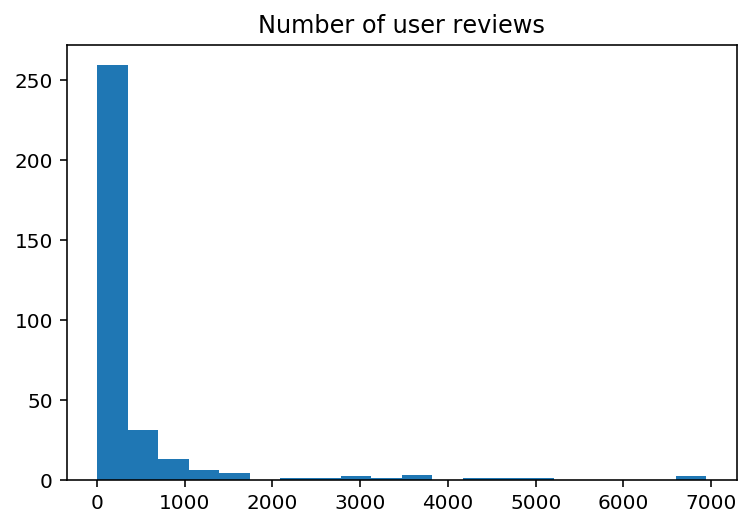

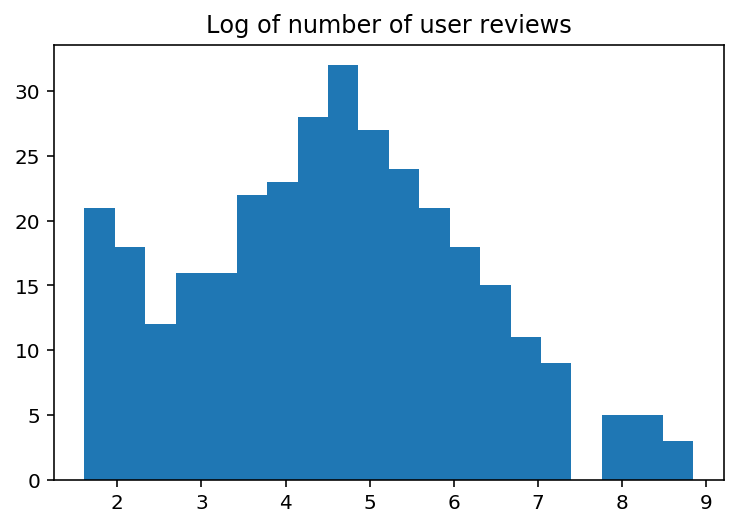

In [49]:
# visualise the number of user reviews
plt.hist(ratings.user_reviews, bins=20)
plt.title('Number of user reviews')
plt.show()

# visualise the log of the number of user reviews
plt.hist(np.log(ratings.user_reviews), bins=20)
plt.title('Log of number of user reviews')
plt.show()

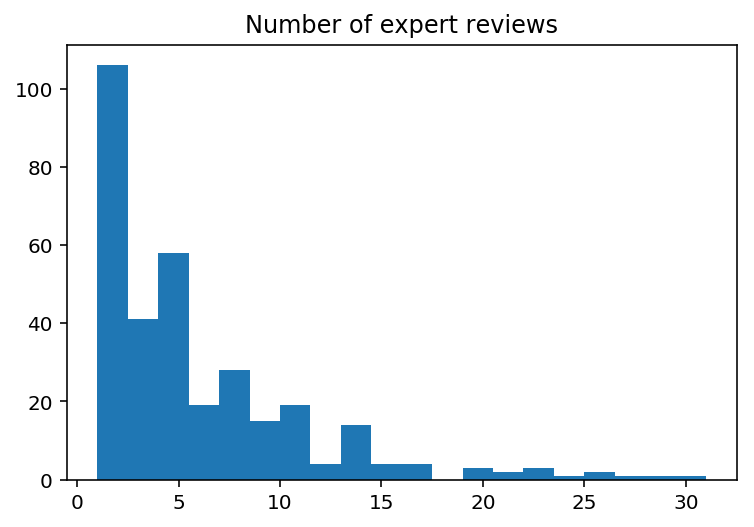

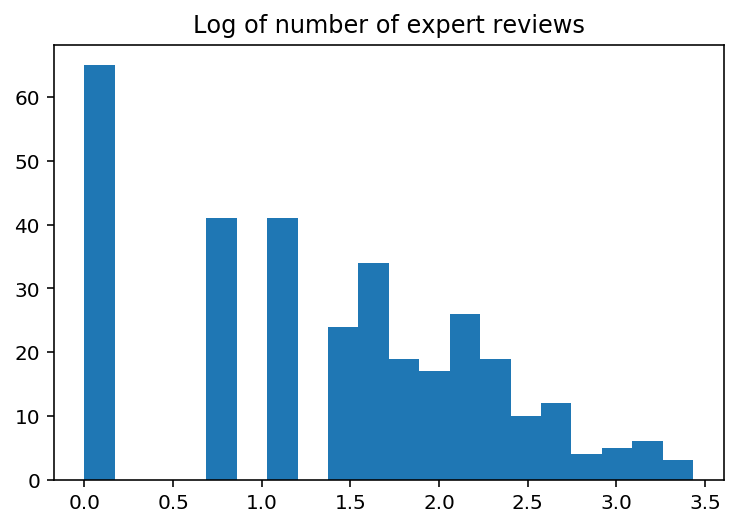

In [50]:
# visualise the number of expert reviews
plt.hist(ratings.expert_reviews, bins=20)
plt.title('Number of expert reviews')
plt.show()

# visualise the log of the number of expert reviews
plt.hist(np.log(ratings.expert_reviews), bins=20)
plt.title('Log of number of expert reviews')
plt.show()

In [51]:
# Score the number of reviews on a scale of between 0 to 1.
mm = MinMaxScaler()
ratings["user_popularity"] = mm.fit_transform(np.log(list(ratings.user_reviews)).reshape(-1,1))
ratings["expert_popularity"] = mm.fit_transform(np.log(list(ratings.expert_reviews)).reshape(-1,1))
ratings["average_popularity_sc"] = (ratings["user_popularity"] + ratings["expert_popularity"]) / 2

# Check ...
print('user_popularity, Min: {}, Max: {}'.format(round(ratings.user_popularity.min(),3), round(ratings.user_popularity.max(),3)))
print('expert_popularity, Min: {}, Max: {}'.format(round(ratings.expert_popularity.min(),3), round(ratings.expert_popularity.max(),3)))
ratings.head(10)

user_popularity, Min: 0.0, Max: 1.0
expert_popularity, Min: 0.0, Max: 1.0


,user_rating_sc,expert_rating_sc,average_rating_sc,user_reviews,expert_reviews,user_popularity,expert_popularity,average_popularity_sc
0,0.84,0.92,0.880,794,7,0.700361,0.566662,0.633511
1,0.96,0.90,0.930,16,13,0.160750,0.746930,0.453840
2,0.88,0.88,0.880,1150,8,0.751556,0.605547,0.678551
3,0.90,0.89,0.895,699,6,0.682749,0.521772,0.602261
4,0.84,0.87,0.855,547,5,0.648862,0.468679,0.558770
5,0.90,0.90,0.900,605,3,0.662790,0.319923,0.491357
6,0.96,0.83,0.895,1040,2,0.737661,0.201849,0.469755
7,0.90,0.87,0.885,191,22,0.503449,0.900132,0.701790
8,0.90,0.93,0.915,340,10,0.583146,0.670528,0.626837
9,0.94,0.94,0.940,79,9,0.381440,0.639846,0.510643


In [53]:
# Save to pickle.
pickle.dump(ratings, open('ratings_current.pkl', 'wb'))